Code Reference: https://github.com/zhihanyang2022/pytorch-sac
I modify the code to handle multiple agents training in Uniyt

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, Independent
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.base_env import ActionTuple

In [2]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda NVIDIA GeForce RTX 3060


### Replay Buffer

In [3]:
from collections import namedtuple, deque

Transition = namedtuple('Transition', 's a r ns d')
Batch = namedtuple('Batch', 's a r ns d')

class ReplayBuffer(object):

    def __init__(self, capacity: int):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, transition: Transition) -> None:
        self.memory.appendleft(transition)

    def ready_for(self, batch_size: int) -> bool:
        if len(self.memory) >= batch_size:
            return True
        return False

    def sample(self, batch_size: int) -> Batch:
        experiences = random.sample(self.memory, batch_size)
        s  = torch.from_numpy(np.vstack([e.s for e in experiences if e is not None])).float().to(device)
        a  = torch.from_numpy(np.vstack([e.a for e in experiences if e is not None])).float().to(device)
        r  = torch.from_numpy(np.vstack([e.r for e in experiences if e is not None])).float().to(device)
        ns  = torch.from_numpy(np.vstack([e.ns for e in experiences if e is not None])).float().to(device)
        d  = torch.from_numpy(np.vstack([e.d for e in experiences if e is not None])).float().to(device)
        return Batch(s, a, r, ns, d)

### NN

In [4]:
def get_net(
        num_in:int,
        num_out:int,
        final_activation,  # e.g. nn.Tanh
        num_hidden_layers:int=5,
        num_neurons_per_hidden_layer:int=64
    ) -> nn.Sequential:

    layers = []

    layers.extend([
        nn.Linear(num_in, num_neurons_per_hidden_layer),
        nn.ReLU(),
    ])

    for _ in range(num_hidden_layers):
        layers.extend([
            nn.Linear(num_neurons_per_hidden_layer, num_neurons_per_hidden_layer),
            nn.ReLU(),
        ])

    layers.append(nn.Linear(num_neurons_per_hidden_layer, num_out))

    if final_activation is not None:
        layers.append(final_activation)

    return nn.Sequential(*layers)

In [5]:
class NormalPolicyNet(nn.Module):

    """Outputs a distribution with parameters learnable by gradient descent."""

    def __init__(self, input_dim, action_dim):
        super(NormalPolicyNet, self).__init__()
        self.shared_net   = get_net(num_in=input_dim, num_out=64, final_activation=nn.ReLU())
        self.means_net    = nn.Linear(64, action_dim)
        self.log_stds_net = nn.Linear(64, action_dim)

    def forward(self, states: torch.tensor):

        out = self.shared_net(states)
        means, log_stds = self.means_net(out), self.log_stds_net(out)

        # the gradient of computing log_stds first and then using torch.exp
        # is much more well-behaved then computing stds directly using nn.Softplus()
        # ref: https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/sac/core.py#L26

        LOG_STD_MAX = 2
        LOG_STD_MIN = -20

        stds = torch.exp(torch.clamp(log_stds, LOG_STD_MIN, LOG_STD_MAX))

        return Independent(Normal(loc=means, scale=stds), reinterpreted_batch_ndims=1)

In [6]:
class QNet(nn.Module):

    """Has little quirks; just a wrapper so that I don't need to call concat many times"""

    def __init__(self, input_dim, action_dim):
        super(QNet, self).__init__()
        self.net = get_net(num_in=input_dim+action_dim, num_out=1, final_activation=None)

    def forward(self, states: torch.tensor, actions: torch.tensor):
        return self.net(torch.cat([states, actions], dim=1))

### Agent

In [7]:
class Agent:

    def __init__(self, input_dim, action_dim):

        self.Normal   = NormalPolicyNet(input_dim=input_dim, action_dim=action_dim).to(device)
        self.Normal_optimizer = optim.Adam(self.Normal.parameters(), lr=1e-3)

        self.Q1       = QNet(input_dim=input_dim, action_dim=action_dim).to(device)
        self.Q1_targ  = QNet(input_dim=input_dim, action_dim=action_dim).to(device)
        self.Q1_targ.load_state_dict(self.Q1.state_dict())
        self.Q1_optimizer = optim.Adam(self.Q1.parameters(), lr=1e-3)

        self.Q2       = QNet(input_dim=input_dim, action_dim=action_dim).to(device)
        self.Q2_targ  = QNet(input_dim=input_dim, action_dim=action_dim).to(device)
        self.Q2_targ.load_state_dict(self.Q2.state_dict())
        self.Q2_optimizer = optim.Adam(self.Q2.parameters(), lr=1e-3)

        self.gamma = 0.99
        self.alpha = 0.1
        self.polyak = 0.995

    # ==================================================================================================================
    # Helper methods (it is generally not my style of using helper methods but here they improve readability)
    # ==================================================================================================================

    def min_i_12(self, a: torch.tensor, b: torch.tensor) -> torch.tensor:
        return torch.min(a, b)

    def sample_action_and_compute_log_pi(self, state, use_reparametrization_trick):
        mu_given_s = self.Normal(state)  # in paper, mu represents the normal distribution
        # in paper, u represents the un-squashed action; nu stands for next u's
        # actually, we can just use reparametrization trick in both Step 12 and 14, but it might be good to separate
        # the two cases for pedagogical purposes, i.e., using reparametrization trick is a must in Step 14
        u = mu_given_s.rsample() if use_reparametrization_trick else mu_given_s.sample()
        a = torch.tanh(u)
        # the following line of code is not numerically stable:
        # log_pi_a_given_s = mu_given_s.log_prob(u) - torch.sum(torch.log(1 - torch.tanh(u) ** 2), dim=1)
        # ref: https://github.com/vitchyr/rlkit/blob/0073d73235d7b4265cd9abe1683b30786d863ffe/rlkit/torch/distributions.py#L358
        # ref: https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/bijectors/tanh.py#L73
        log_pi_a_given_s = mu_given_s.log_prob(u) - (2 * (np.log(2) - u - F.softplus(-2 * u))).sum(dim=1)
        return a, log_pi_a_given_s

    def clip_gradient(self, net: nn.Module) -> None:
        for param in net.parameters():
            param.grad.data.clamp_(-1, 1)

    def polyak_update(self, old_net: nn.Module, new_net: nn.Module) -> None:
        for old_param, new_param in zip(old_net.parameters(), new_net.parameters()):
            old_param.data.copy_(old_param.data * self.polyak + new_param.data * (1 - self.polyak))

    # ==================================================================================================================
    # Methods for learning
    # ==================================================================================================================

    def update_networks(self, b: Batch):

        # ========================================
        # Step 12: calculating targets
        # ========================================

        with torch.no_grad():

            na, log_pi_na_given_ns = self.sample_action_and_compute_log_pi(b.ns, use_reparametrization_trick=False)
            targets = b.r + self.gamma * (1 - b.d) * \
                      (self.min_i_12(self.Q1_targ(b.ns, na), self.Q2_targ(b.ns, na)) - self.alpha * log_pi_na_given_ns)

        # ========================================
        # Step 13: learning the Q functions
        # ========================================

        Q1_predictions = self.Q1(b.s, b.a)
        Q1_loss = torch.mean((Q1_predictions - targets) ** 2)

        self.Q1_optimizer.zero_grad()
        Q1_loss.backward()
        self.clip_gradient(net=self.Q1)
        self.Q1_optimizer.step()

        Q2_predictions = self.Q2(b.s, b.a)
        Q2_loss = torch.mean((Q2_predictions - targets) ** 2)

        self.Q2_optimizer.zero_grad()
        Q2_loss.backward()
        self.clip_gradient(net=self.Q2)
        self.Q2_optimizer.step()

        # ========================================
        # Step 14: learning the policy
        # ========================================

        for param in self.Q1.parameters():
            param.requires_grad = False
        for param in self.Q2.parameters():
            param.requires_grad = False

        a, log_pi_a_given_s = self.sample_action_and_compute_log_pi(b.s, use_reparametrization_trick=True)
        policy_loss = - torch.mean(self.min_i_12(self.Q1(b.s, a), self.Q2(b.s, a)) - self.alpha * log_pi_a_given_s)

        self.Normal_optimizer.zero_grad()
        policy_loss.backward()
        self.clip_gradient(net=self.Normal)
        self.Normal_optimizer.step()

        for param in self.Q1.parameters():
            param.requires_grad = True
        for param in self.Q2.parameters():
            param.requires_grad = True

        # ========================================
        # Step 15: update target networks
        # ========================================

        with torch.no_grad():
            self.polyak_update(old_net=self.Q1_targ, new_net=self.Q1)
            self.polyak_update(old_net=self.Q2_targ, new_net=self.Q2)
        return float(Q1_loss), float(policy_loss)

    def act(self, state)-> np.array:
        # state: torch.FloatTensor(s).to(device)
        action, _ = self.sample_action_and_compute_log_pi(state, use_reparametrization_trick=False)
        return action.detach().cpu().numpy()  # no need to detach first because we are not using the reparametrization trick

    def save_actor(self, save_dir: str, filename: str) -> None:
        os.makedirs(save_dir, exist_ok=True)
        torch.save(self.Normal.state_dict(), os.path.join(save_dir, filename))

    def load_actor(self, save_dir: str, filename: str) -> None:
        self.Normal.load_state_dict(torch.load(os.path.join(save_dir, filename)))

### Instinate agent 

In [8]:
N_STATES  = 243
N_ACTIONS =39

N_AGENTS = 3  
hidden_units = 256

In [9]:
agent = Agent(
    input_dim=N_STATES,
    action_dim=N_ACTIONS
)

# Training loop

In [29]:
env = UnityEnvironment(file_name= None, base_port=5004)

In [30]:
env.reset()
behaviorNames = list(env.behavior_specs.keys())
behaviorName = behaviorNames[0]
print(behaviorName)

Walker?team=0


In [31]:
batch_size = 1024
max_steps = 1500  #15M in Walker.yaml

In [32]:
buf = ReplayBuffer(capacity=int(2e6))  #2M in Walker.yaml

In [33]:
step = 1
total_reward = 0
rewardLst = []
Q1LossLst = []
PolicyLossLst = []

while (step < max_steps):
    env.reset()  
    DecisionSteps, TerminalSteps = env.get_steps(behaviorName)
    episode_done = False 
    
    while (not episode_done):
        step = step + 1
        if(step %100 == 0):
            print(step, end= ",")
            rewardLst.append(total_reward)
            total_reward = 0
            
        # ==================================================
        # getting the tuple (s, a, r, s', done)
        # ==================================================
        s = DecisionSteps.obs[0]
        a = agent.act(torch.FloatTensor(s).to(device))
        a = ActionTuple(np.array(a, dtype=np.float32))
        env.set_actions(behaviorName, a)
        env.step()
        a = a._continuous #convert from ActionTuple to np.array
        NextDecisionSteps, NextTerminalSteps = env.get_steps(behaviorName)    

        #if next terminal step has agents, then collect transistions and restart training 
        if(len(NextTerminalSteps) > 0): 
            idxLst = []
            for idx in NextTerminalSteps.agent_id:  #collect agent idx in Terminal setps
                idxLst.append(idx)
            s = [s[i] for i in idxLst]
            a = [a[i] for i in idxLst]
            ns = NextTerminalSteps.obs[0]
            reward = NextTerminalSteps.reward
            reward = np.expand_dims(reward, axis=1)
            done = np.array([[1]]*len(NextTerminalSteps)) 
            buf.push(Transition(s, a, reward, ns, done))
            #print("Agent", NextTerminalSteps.agent_id, " goes to Terminal steps. Finish this training episode.")
            episode_done = True
        #if next decision step does not have all agents, then collect transistions and restart training 
        elif (len(NextDecisionSteps) != N_AGENTS):
            idxLst = []
            for idx in NextDecisionSteps.agent_id:
                idxLst.append(idx)
            s = [s[i] for i in idxLst]
            a = [a[i] for i in idxLst]
            ns = NextDecisionSteps.obs[0]
            reward = NextDecisionSteps.reward
            reward = np.expand_dims(reward, axis=1)
            done = np.array([[0]]*len(NextTerminalSteps)) 
            buf.push(Transition(s, a, reward, ns, done))
            #print("Agent", NextDecisionSteps.agent_id, " are not in Decision steps. Finish this training episode.")
            episode_done = True
        else: 
            ns = NextDecisionSteps.obs[0]
            reward = NextDecisionSteps.reward
            reward = np.expand_dims(reward, axis=1)
            total_reward = total_reward + np.mean(reward)
            done = np.array([[0]]*N_AGENTS ) 
            buf.push(Transition(s, a, reward, ns, done))
            DecisionSteps, TerminalSteps = NextDecisionSteps, NextTerminalSteps

        # ==================================================
        # update the parameters
        # ==================================================
        if buf.ready_for(batch_size):
            Q1_loss, policy_loss = agent.update_networks(buf.sample(batch_size))
            if(step %100 == 0):
                Q1LossLst.append(Q1_loss)
                PolicyLossLst.append(policy_loss)

100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,

In [34]:
env.close()

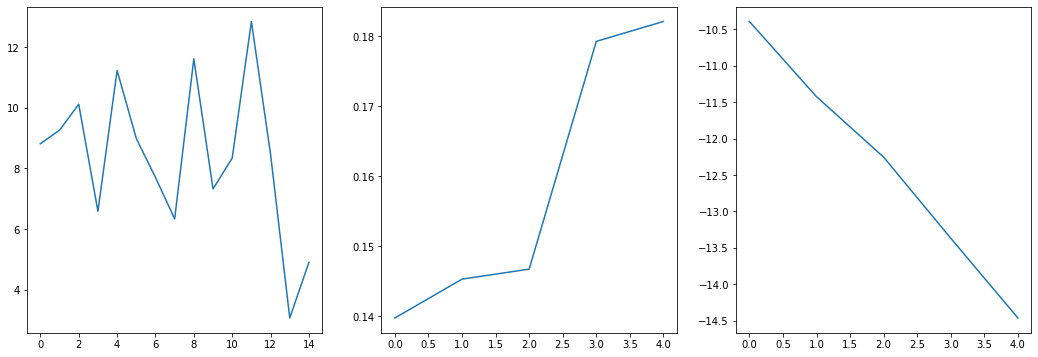

In [35]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(18, 6))
fig.add_subplot(1, 3, 1)  # 1 row, 3 columns
plt.plot(rewardLst)

fig.add_subplot(1, 3, 2) 
plt.plot(Q1LossLst)

fig.add_subplot(1, 3, 3) 
plt.plot(PolicyLossLst)

plt.show()